<a href="https://colab.research.google.com/github/pardeeptiwari/PardeepTiwari/blob/main/churn_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Prediction - Case Study
## Predicting Customer Churn for July 2025

**Objective:** Build a machine learning model to predict churn probability for 9,659 active customers based on 6 months of historical data (Jan-Jun 2025)

**Dataset:** 10,000 customers, 983 features, 341 churned in June 2025

## 1. Import Libraries and Load Data

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the dataset from the same directory
df = pd.read_excel('Case Study data– Churn Prediction.xlsx', sheet_name='CASE_STADY')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['CHURN_F'].value_counts())
print(f"\nChurn rate: {df['CHURN_F'].mean()*100:.2f}%")

Dataset shape: (10000, 983)

Target variable distribution:
CHURN_F
0    9659
1     341
Name: count, dtype: int64

Churn rate: 3.41%


## 2. Exploratory Data Analysis (EDA)

In [4]:
# Basic information about the dataset
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total customers: {len(df)}")
print(f"Total features: {df.shape[1]}")
print(f"Churned customers: {df['CHURN_F'].sum()}")
print(f"Active customers: {len(df) - df['CHURN_F'].sum()}")
print(f"\nData types:")
print(df.dtypes.value_counts())

DATASET OVERVIEW
Total customers: 10000
Total features: 983
Churned customers: 341
Active customers: 9659

Data types:
float64    918
int64       58
object       7
Name: count, dtype: int64


In [5]:
# Check for missing values
missing_summary = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum().values,
    'missing_pct': (df.isnull().sum().values / len(df) * 100)
})
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_pct', ascending=False)

print(f"\nColumns with missing values: {len(missing_summary)}")
print(f"\nTop 20 columns with highest missing percentage:")
print(missing_summary.head(20))


Columns with missing values: 913

Top 20 columns with highest missing percentage:
                     column  missing_count  missing_pct
29        REVENUE_OTHERS_M6          10000        100.0
28        REVENUE_OTHERS_M5          10000        100.0
27        REVENUE_OTHERS_M4          10000        100.0
26        REVENUE_OTHERS_M3          10000        100.0
25        REVENUE_OTHERS_M2          10000        100.0
24        REVENUE_OTHERS_M1          10000        100.0
445       PAYMENT_CHEQUE_M2          10000        100.0
444       PAYMENT_CHEQUE_M1          10000        100.0
478   PAYMENT_CHEQUE_ACT_M5          10000        100.0
479   PAYMENT_CHEQUE_ACT_M6          10000        100.0
517  PAY_MORE_90DAYS_INV_M2          10000        100.0
510       PAY_90DAYS_INV_M1          10000        100.0
509       PAY_60DAYS_INV_M6          10000        100.0
515       PAY_90DAYS_INV_M6          10000        100.0
516  PAY_MORE_90DAYS_INV_M1          10000        100.0
512       PAY_90DAYS_

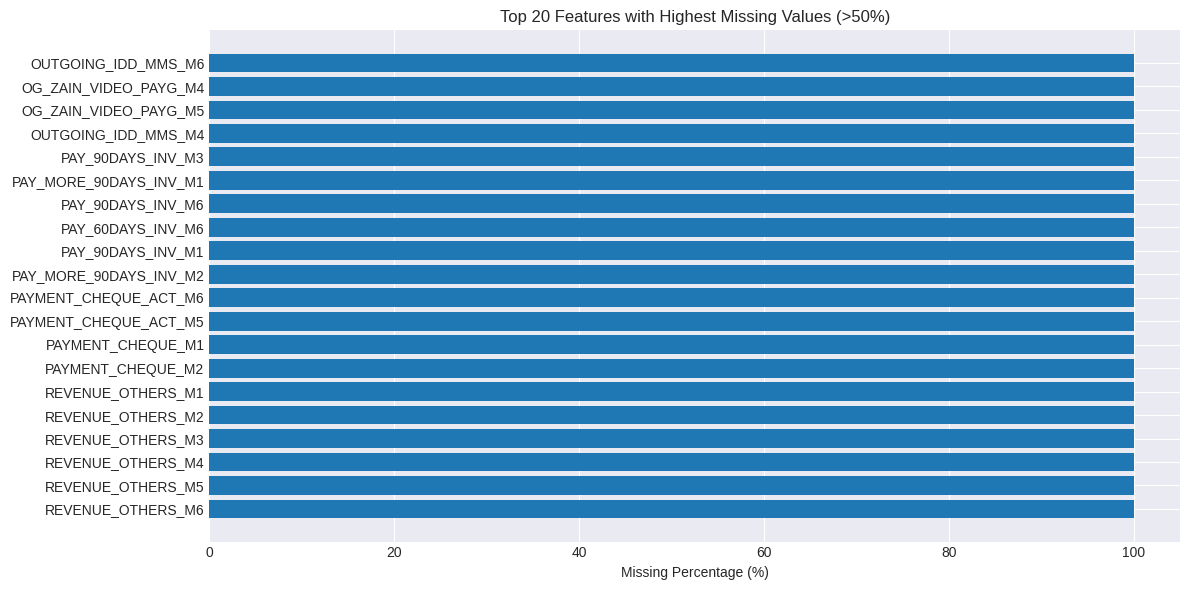


Columns with >90% missing values: 398
These columns will likely be dropped during feature engineering.


In [6]:
# Visualize missing values for columns with >50% missing
high_missing = missing_summary[missing_summary['missing_pct'] > 50]

if len(high_missing) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(high_missing['column'].head(20), high_missing['missing_pct'].head(20))
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 20 Features with Highest Missing Values (>50%)')
    plt.tight_layout()
    plt.show()

    print(f"\nColumns with >90% missing values: {len(missing_summary[missing_summary['missing_pct'] > 90])}")
    print("These columns will likely be dropped during feature engineering.")

In [7]:
# Analyze categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'MSISDN' in categorical_cols:
    categorical_cols.remove('MSISDN')  # Remove customer ID

print(f"\nCategorical features: {len(categorical_cols)}")
print(categorical_cols)

# Display unique values for each categorical feature
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head(5))


Categorical features: 7
['PREPOST_PAID', 'BS_TYPE', 'MAIN_PLAN', 'DEVICE_NAME', 'DEVICE_TYPE', 'NATIONALLITY', 'DEVICE_MODEL']

PREPOST_PAID: 1 unique values
PREPOST_PAID
POST    10000
Name: count, dtype: int64

BS_TYPE: 1 unique values
BS_TYPE
VOICE    10000
Name: count, dtype: int64

MAIN_PLAN: 32 unique values
MAIN_PLAN
M12NC     2000
NP20NC    1574
NP10NC    1171
NP15NC    1153
NP30NC     961
Name: count, dtype: int64

DEVICE_NAME: 89 unique values
DEVICE_NAME
APPLE      6343
SAMSUNG    1629
HUAWEI      998
NOKIA       156
XIAOMI       73
Name: count, dtype: int64

DEVICE_TYPE: 3 unique values
DEVICE_TYPE
4G    9227
2G     178
3G     143
Name: count, dtype: int64

NATIONALLITY: 58 unique values
NATIONALLITY
KWT    6528
EGY    1020
SYR     351
IND     324
PAK     318
Name: count, dtype: int64

DEVICE_MODEL: 622 unique values
DEVICE_MODEL
IPHONE 15 PRO MAX(A3106)    852
IPHONE 14 PRO MAX(A2894)    645
IPHONE 13 PRO MAX(A2643)    436
IPHONE 12 PRO MAX(A2411)    435
IPHONE 15 PRO(A310

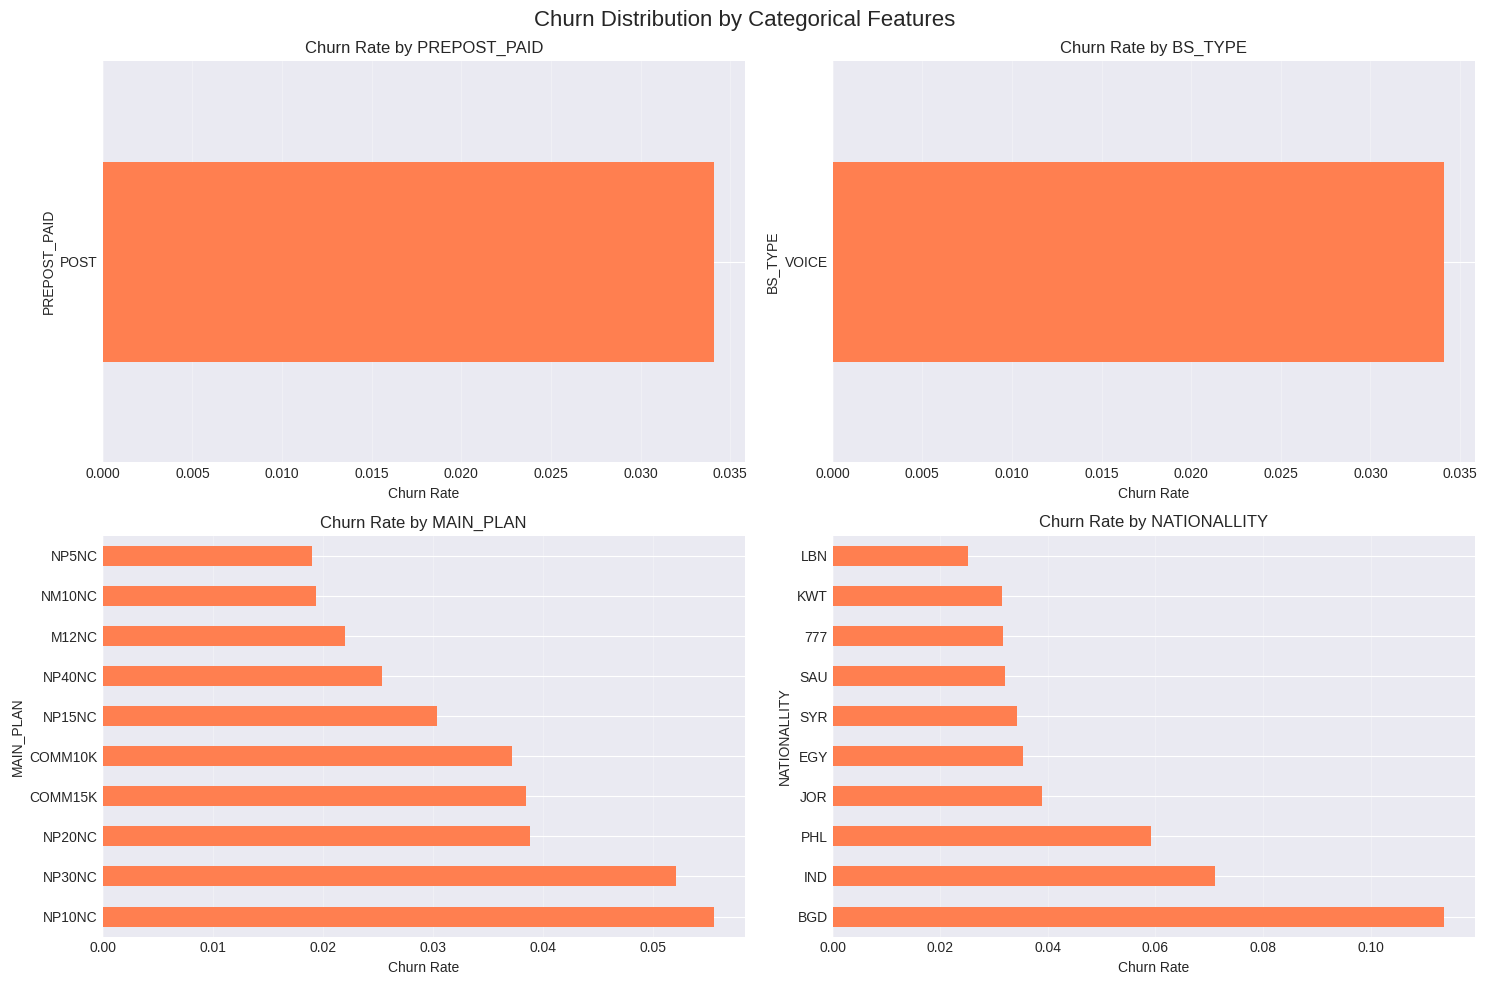

In [8]:
# Visualize churn distribution by key categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Churn Distribution by Categorical Features', fontsize=16)

# Plot for each categorical feature
for idx, col in enumerate(['PREPOST_PAID', 'BS_TYPE', 'MAIN_PLAN', 'NATIONALLITY'][:4]):
    if col in df.columns:
        ax = axes[idx // 2, idx % 2]
        churn_by_cat = df.groupby(col)['CHURN_F'].agg(['sum', 'count', 'mean'])
        churn_by_cat = churn_by_cat[churn_by_cat['count'] > 50].sort_values('mean', ascending=False).head(10)

        churn_by_cat['mean'].plot(kind='barh', ax=ax, color='coral')
        ax.set_xlabel('Churn Rate')
        ax.set_title(f'Churn Rate by {col}')
        ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Revenue columns found: 54
['REVENUE_DATA_M1', 'REVENUE_DATA_M2', 'REVENUE_DATA_M3', 'REVENUE_DATA_M4', 'REVENUE_DATA_M5', 'REVENUE_DATA_M6', 'REVENUE_IDD_M1', 'REVENUE_IDD_M2', 'REVENUE_IDD_M3', 'REVENUE_IDD_M4', 'REVENUE_IDD_M5', 'REVENUE_IDD_M6']


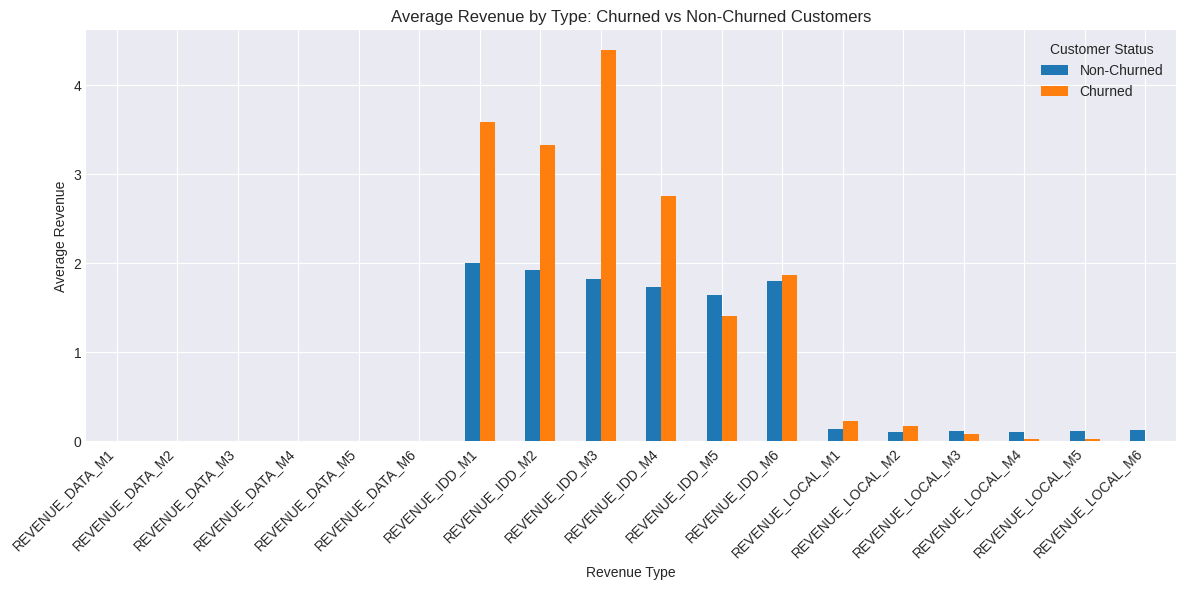

In [9]:
# Analyze numerical features - Revenue patterns
revenue_cols = [col for col in df.columns if 'REVENUE' in col and any(f'M{i}' in col for i in range(1, 7))]
print(f"\nRevenue columns found: {len(revenue_cols)}")
print(revenue_cols[:12])  # Show first 12

# Calculate average revenue per month for churned vs non-churned
if len(revenue_cols) > 0:
    revenue_comparison = df.groupby('CHURN_F')[revenue_cols[:18]].mean().T
    revenue_comparison.columns = ['Non-Churned', 'Churned']

    fig, ax = plt.subplots(figsize=(12, 6))
    revenue_comparison.plot(kind='bar', ax=ax)
    plt.title('Average Revenue by Type: Churned vs Non-Churned Customers')
    plt.xlabel('Revenue Type')
    plt.ylabel('Average Revenue')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Customer Status')
    plt.tight_layout()
    plt.show()


TEMPORAL ANALYSIS - Revenue Trends

Non-Churned Customers - Average Monthly Total Revenue:
REVENUE_TOT_M1    28.477945
REVENUE_TOT_M2    28.506019
REVENUE_TOT_M3    27.118390
REVENUE_TOT_M4    29.317153
REVENUE_TOT_M5    29.580770
REVENUE_TOT_M6    28.628317
dtype: float64

Churned Customers - Average Monthly Total Revenue:
REVENUE_TOT_M1    57.592358
REVENUE_TOT_M2    26.263072
REVENUE_TOT_M3    27.216282
REVENUE_TOT_M4    51.211266
REVENUE_TOT_M5    47.084179
REVENUE_TOT_M6    28.846500
dtype: float64


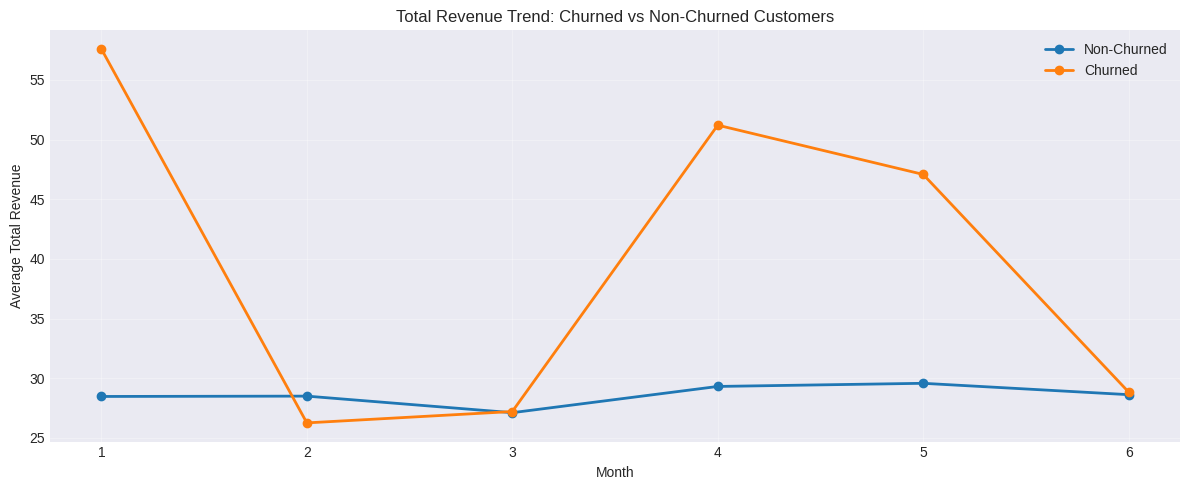

In [10]:
# Analyze usage patterns over time (M1-M6)
# Create aggregated features to see trends
print("\n" + "="*80)
print("TEMPORAL ANALYSIS - Revenue Trends")
print("="*80)

# Example: Total revenue per month
monthly_revenue_cols = [col for col in df.columns if 'REVENUE_TOT' in col and 'M' in col]
if len(monthly_revenue_cols) >= 6:
    for status, label in [(0, 'Non-Churned'), (1, 'Churned')]:
        monthly_avg = df[df['CHURN_F'] == status][monthly_revenue_cols].mean()
        print(f"\n{label} Customers - Average Monthly Total Revenue:")
        print(monthly_avg)

# Visualize trend
if len(monthly_revenue_cols) >= 6:
    plt.figure(figsize=(12, 5))
    for status, label in [(0, 'Non-Churned'), (1, 'Churned')]:
        monthly_avg = df[df['CHURN_F'] == status][monthly_revenue_cols].mean()
        plt.plot(range(1, len(monthly_avg)+1), monthly_avg.values, marker='o', label=label, linewidth=2)

    plt.xlabel('Month')
    plt.ylabel('Average Total Revenue')
    plt.title('Total Revenue Trend: Churned vs Non-Churned Customers')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering

Key strategies:
1. Handle missing values appropriately
2. Create aggregate features (avg, trend, volatility)
3. Engineer temporal features (month-over-month changes)
4. Encode categorical variables
5. Remove low-variance and highly correlated features

In [11]:
# Create a copy for feature engineering
df_fe = df.copy()

# Separate features and target
X = df_fe.drop(['CHURN_F', 'MSISDN'], axis=1)
y = df_fe['CHURN_F']

print(f"Original feature count: {X.shape[1]}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Original feature count: 981
Target distribution: {0: 9659, 1: 341}


In [12]:
# Step 1: Remove columns with >90% missing values
missing_threshold = 0.90
missing_pct = X.isnull().sum() / len(X)
cols_to_drop = missing_pct[missing_pct > missing_threshold].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with >{missing_threshold*100}% missing values")
X = X.drop(columns=cols_to_drop)
print(f"Remaining features: {X.shape[1]}")

Dropping 398 columns with >90.0% missing values
Remaining features: 583


In [13]:
# Step 2: Create aggregated features from monthly data
# This captures overall behavior rather than individual months

print("\nCreating aggregated features...")

# Define feature groups by prefix
feature_prefixes = ['REVENUE_DATA', 'REVENUE_IDD', 'REVENUE_LOCAL', 'REVENUE_SMS',
                   'REVENUE_ROAM', 'REVENUE_TOT', 'TOTAL_CALL_MOU', 'TOTAL_DATA_MB']

aggregated_features = pd.DataFrame(index=X.index)

for prefix in feature_prefixes:
    # Find all monthly columns for this prefix
    monthly_cols = [col for col in X.columns if prefix in col and any(f'M{i}' in col for i in range(1, 7))]

    if len(monthly_cols) > 0:
        # Calculate aggregate statistics
        aggregated_features[f'{prefix}_AVG'] = X[monthly_cols].mean(axis=1)
        aggregated_features[f'{prefix}_STD'] = X[monthly_cols].std(axis=1)
        aggregated_features[f'{prefix}_MAX'] = X[monthly_cols].max(axis=1)
        aggregated_features[f'{prefix}_MIN'] = X[monthly_cols].min(axis=1)

        # Trend: difference between last month and first month
        if len(monthly_cols) >= 2:
            last_col = [col for col in monthly_cols if 'M6' in col]
            first_col = [col for col in monthly_cols if 'M1' in col]
            if last_col and first_col:
                aggregated_features[f'{prefix}_TREND'] = X[last_col[0]] - X[first_col[0]]

print(f"Created {aggregated_features.shape[1]} aggregated features")
print(aggregated_features.head())


Creating aggregated features...
Created 29 aggregated features
   REVENUE_DATA_AVG  REVENUE_DATA_STD  REVENUE_DATA_MAX  REVENUE_DATA_MIN  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               NaN               NaN               NaN               NaN   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   REVENUE_DATA_TREND  REVENUE_IDD_AVG  REVENUE_IDD_STD  REVENUE_IDD_MAX  \
0                 NaN              NaN              NaN              NaN   
1                 0.0              NaN              NaN              NaN   
2                 NaN              NaN              NaN              NaN   
3                 0.0              NaN              NaN              NaN   
4                 NaN              NaN              NaN              NaN   

   REVENUE_IDD_M

In [14]:
# Step 3: Handle categorical variables
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical features to encode: {len(categorical_features)}")
print(categorical_features)

# For high-cardinality categoricals (like DEVICE_MODEL), we'll create simplified features
encoded_features = pd.DataFrame(index=X.index)

for col in categorical_features:
    if col in X.columns:
        # Handle missing values
        X[col] = X[col].fillna('MISSING')

        # For high cardinality, group rare categories
        if X[col].nunique() > 50:
            # Keep top 20 categories, group rest as 'OTHER'
            top_categories = X[col].value_counts().head(20).index
            X[col] = X[col].apply(lambda x: x if x in top_categories else 'OTHER')

        # Label encoding
        le = LabelEncoder()
        encoded_features[f'{col}_ENCODED'] = le.fit_transform(X[col])

print(f"Created {encoded_features.shape[1]} encoded features")


Categorical features to encode: 7
['PREPOST_PAID', 'BS_TYPE', 'MAIN_PLAN', 'DEVICE_NAME', 'DEVICE_TYPE', 'NATIONALLITY', 'DEVICE_MODEL']
Created 7 encoded features


In [15]:
# Step 4: Select numerical features and handle remaining missing values
numerical_features = X.select_dtypes(include=['int64', 'float64']).copy()

# Impute missing values with median (more robust to outliers)
imputer = SimpleImputer(strategy='median')
numerical_features_imputed = pd.DataFrame(
    imputer.fit_transform(numerical_features),
    columns=numerical_features.columns,
    index=numerical_features.index
)

print(f"\nNumerical features after imputation: {numerical_features_imputed.shape[1]}")
print(f"Remaining missing values: {numerical_features_imputed.isnull().sum().sum()}")


Numerical features after imputation: 576
Remaining missing values: 0


In [16]:
# Step 5: Combine all engineered features
X_engineered = pd.concat([
    numerical_features_imputed,
    aggregated_features,
    encoded_features
], axis=1)

# Remove any remaining NaN or inf values
X_engineered = X_engineered.replace([np.inf, -np.inf], np.nan)
X_engineered = X_engineered.fillna(0)

print(f"\nFinal engineered feature set: {X_engineered.shape[1]} features")
print(f"Any missing values: {X_engineered.isnull().sum().sum()}")
print(f"\nFeature engineering complete!")


Final engineered feature set: 612 features
Any missing values: 0

Feature engineering complete!


In [17]:
# Step 6: Feature selection - Remove low variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance (quasi-constant features)
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_engineered)
selected_feature_names = X_engineered.columns[selector.get_support()].tolist()

X_final = pd.DataFrame(X_selected, columns=selected_feature_names, index=X_engineered.index)

print(f"Features after variance threshold: {X_final.shape[1]}")
print(f"Removed {X_engineered.shape[1] - X_final.shape[1]} low-variance features")

Features after variance threshold: 516
Removed 96 low-variance features


## 4. Model Development

Strategy:
1. Split data into train/validation sets
2. Train multiple models and compare performance
3. Use appropriate evaluation metrics for imbalanced data (ROC-AUC, Precision-Recall)
4. Select best model based on business context

In [18]:
# Split data - stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set churn rate: {y_train.mean()*100:.2f}%")
print(f"Test set churn rate: {y_test.mean()*100:.2f}%")

Training set: (8000, 516)
Test set: (2000, 516)

Training set churn rate: 3.41%
Test set churn rate: 3.40%


In [19]:
# Scale features for models that benefit from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")

Features scaled successfully!


In [20]:
# Define models to compare
# Using class_weight='balanced' to handle imbalanced data

models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Handle imbalance
        random_state=42,
        n_jobs=-1
    )
}

print(f"Models to train: {list(models.keys())}")

Models to train: ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']


In [21]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for Logistic Regression, unscaled for tree-based models
    if name == 'Logistic Regression':
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test

    # Train model
    model.fit(X_train_use, y_train)

    # Predictions
    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1_score': f1,
        'cv_mean': cv_mean,
        'cv_std': cv_std
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  CV ROC-AUC: {cv_mean:.4f} (+/- {cv_std:.4f})")

print("\nAll models trained!")


Training Logistic Regression...
  Accuracy: 0.9125
  ROC-AUC: 0.8053
  F1-Score: 0.3191
  CV ROC-AUC: 0.8457 (+/- 0.0302)

Training Random Forest...
  Accuracy: 0.9680
  ROC-AUC: 0.8908
  F1-Score: 0.4839
  CV ROC-AUC: 0.8825 (+/- 0.0280)

Training Gradient Boosting...
  Accuracy: 0.9685
  ROC-AUC: 0.9063
  F1-Score: 0.4522
  CV ROC-AUC: 0.9112 (+/- 0.0195)

Training XGBoost...
  Accuracy: 0.9710
  ROC-AUC: 0.9369
  F1-Score: 0.5735
  CV ROC-AUC: 0.8922 (+/- 0.0300)

All models trained!



MODEL COMPARISON
              Model  Accuracy  ROC-AUC  F1-Score  CV ROC-AUC
Logistic Regression    0.9125 0.805276  0.319066    0.845691
      Random Forest    0.9680 0.890787  0.483871    0.882479
  Gradient Boosting    0.9685 0.906311  0.452174    0.911158
            XGBoost    0.9710 0.936937  0.573529    0.892236


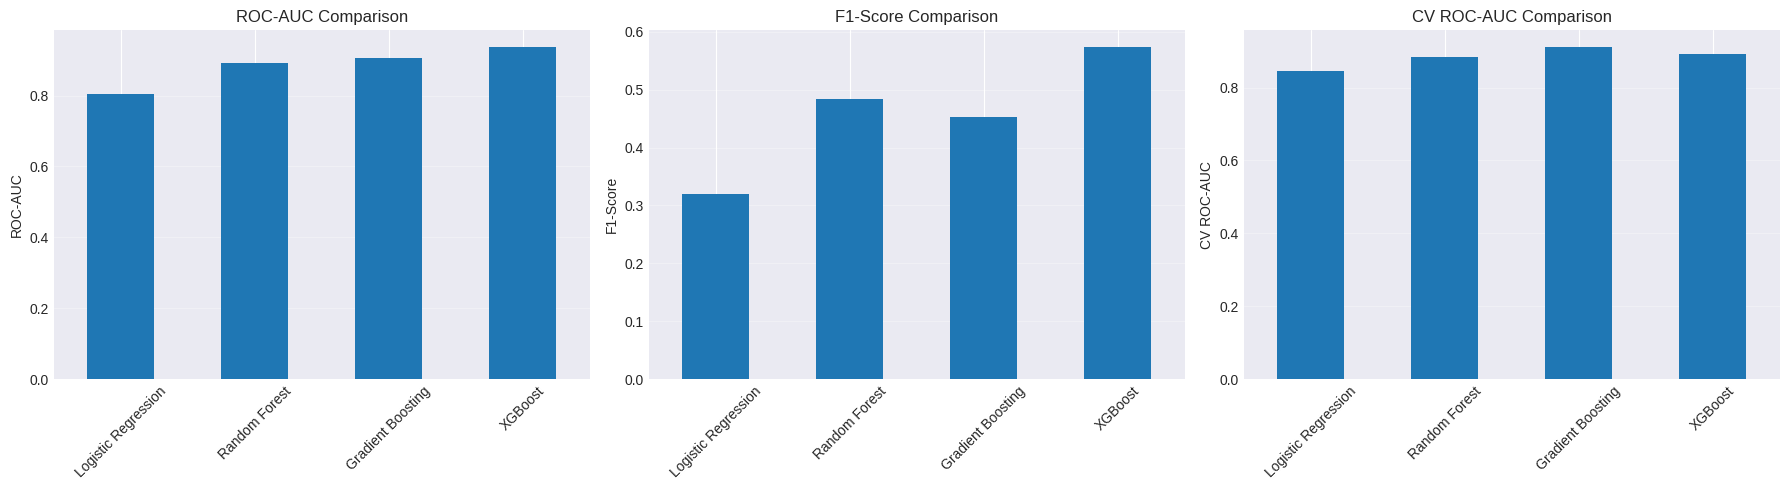

In [22]:
# Compare models visually
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'CV ROC-AUC': [results[m]['cv_mean'] for m in results.keys()]
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['ROC-AUC', 'F1-Score', 'CV ROC-AUC']
for idx, metric in enumerate(metrics):
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=axes[idx], legend=False)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation and Selection

In [23]:
# Select best model based on ROC-AUC (most appropriate for imbalanced classification)
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']

print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {results[best_model_name]['roc_auc']:.4f}")

# Get predictions from best model
y_pred_best = results[best_model_name]['y_pred']
y_pred_proba_best = results[best_model_name]['y_pred_proba']

Best Model: XGBoost
ROC-AUC Score: 0.9369



DETAILED EVALUATION - XGBoost

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.98      0.98      0.98      1932
       Churn       0.57      0.57      0.57        68

    accuracy                           0.97      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.97      0.97      0.97      2000


Confusion Matrix:
[[1903   29]
 [  29   39]]


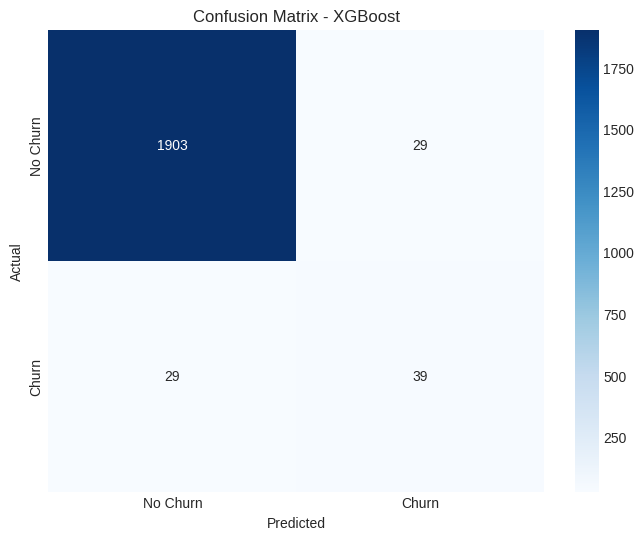

In [24]:
# Detailed evaluation of best model
print("\n" + "="*80)
print(f"DETAILED EVALUATION - {best_model_name}")
print("="*80)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

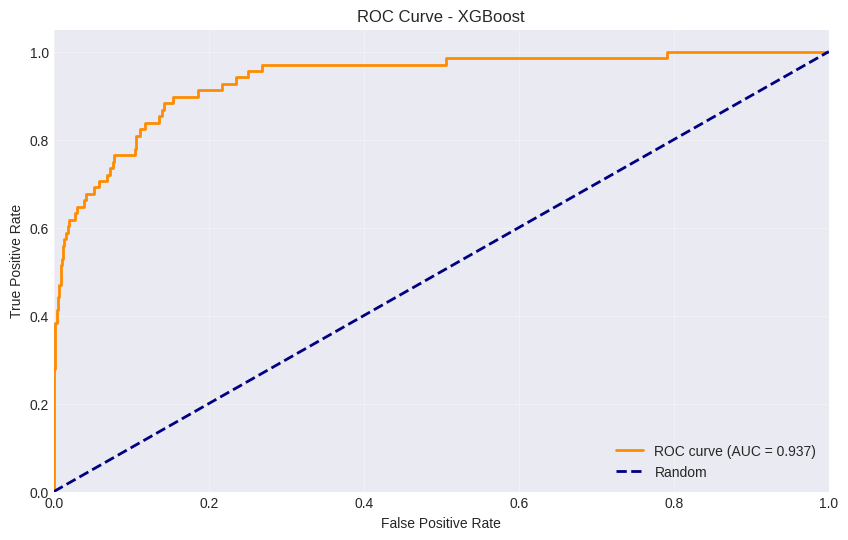

In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

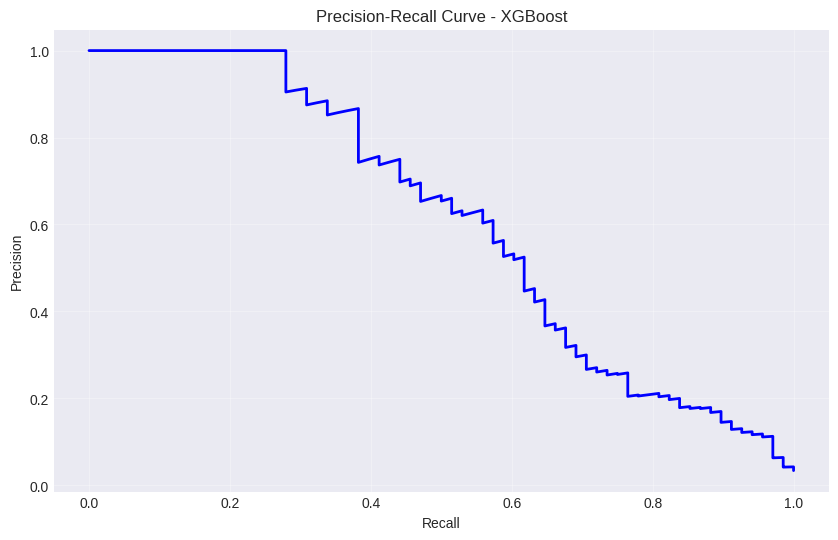

In [26]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.grid(alpha=0.3)
plt.show()


Top 20 Most Important Features:
                     feature  importance
263     TOTAL_OUTSTANDING_M1    0.035442
275              COMMIT_FLAG    0.032128
443     DEVICE_ADDON_PERC_M1    0.021464
431        MAIN_PLAN_PERC_M1    0.016288
276           COMMIT_MONTH_1    0.014137
118     INCOMING_PSTN_DUR_M1    0.013918
244           PAYMENT_ACT_M1    0.013281
402      DEVICE_ADDON_REV_M3    0.012683
487          REVENUE_IDD_AVG    0.011333
9             REVENUE_IDD_M4    0.011234
447     DEVICE_ADDON_PERC_M5    0.009579
511        MAIN_PLAN_ENCODED    0.009304
488          REVENUE_IDD_STD    0.008933
161     OUTGOING_ZAIN_DUR_M2    0.008869
162     OUTGOING_ZAIN_DUR_M3    0.008793
125  INCOMING_WATNIYA_DUR_M2    0.008705
77    OUTGOING_ONNET_CALL_M4    0.007963
497          REVENUE_SMS_AVG    0.007568
300        SC_CNTR_SUS_NP_3M    0.007364
279       OUT_COMMIT_MONTH_1    0.007350


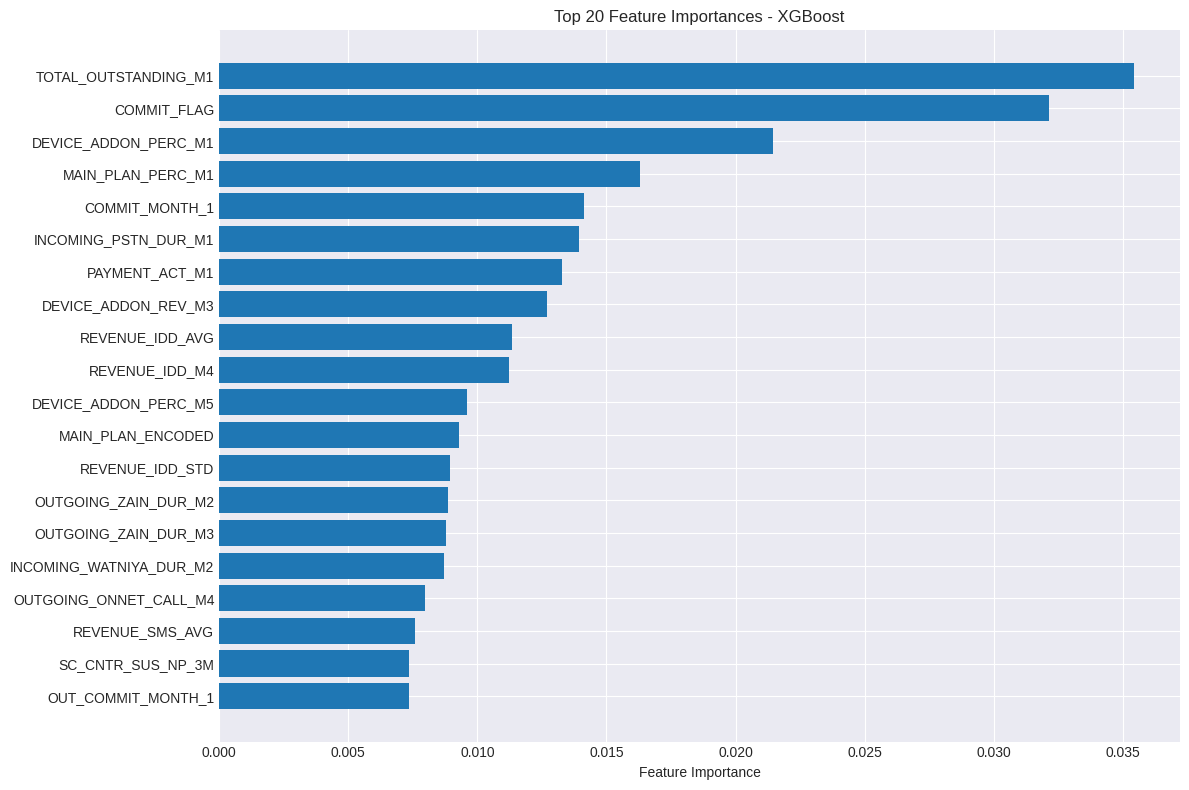

In [27]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_final.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))

    # Visualize top features
    plt.figure(figsize=(12, 8))
    plt.barh(range(20), feature_importance['importance'].head(20))
    plt.yticks(range(20), feature_importance['feature'].head(20))
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # For Logistic Regression
    coef_df = pd.DataFrame({
        'feature': X_final.columns,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', ascending=False)

    print("\nTop 20 Most Positive Coefficients:")
    print(coef_df.head(20))

    print("\nTop 20 Most Negative Coefficients:")
    print(coef_df.tail(20))

## 6. Predict Churn Probability for July 2025

Now we'll predict churn probability for the 9,659 customers who didn't churn in June 2025

In [29]:
# Get non-churned customers (those who didn't churn in June)
non_churned_customers = df_fe[df_fe['CHURN_F'] == 0].copy()
print(f"Total non-churned customers: {len(non_churned_customers)}")

# Prepare features for prediction - apply ALL the same transformations
X_predict_raw = non_churned_customers.drop(['CHURN_F', 'MSISDN'], axis=1)
customer_ids = non_churned_customers['MSISDN'].values

# Step 1: Drop same columns with >90% missing
X_predict_raw = X_predict_raw.drop(columns=[col for col in cols_to_drop if col in X_predict_raw.columns])

# Step 2: Create aggregated features (same as training)
aggregated_features_predict = pd.DataFrame(index=X_predict_raw.index)

for prefix in feature_prefixes:
    monthly_cols = [col for col in X_predict_raw.columns if prefix in col and any(f'M{i}' in col for i in range(1, 7))]

    if len(monthly_cols) > 0:
        aggregated_features_predict[f'{prefix}_AVG'] = X_predict_raw[monthly_cols].mean(axis=1)
        aggregated_features_predict[f'{prefix}_STD'] = X_predict_raw[monthly_cols].std(axis=1)
        aggregated_features_predict[f'{prefix}_MAX'] = X_predict_raw[monthly_cols].max(axis=1)
        aggregated_features_predict[f'{prefix}_MIN'] = X_predict_raw[monthly_cols].min(axis=1)

        if len(monthly_cols) >= 2:
            last_col = [col for col in monthly_cols if 'M6' in col]
            first_col = [col for col in monthly_cols if 'M1' in col]
            if last_col and first_col:
                aggregated_features_predict[f'{prefix}_TREND'] = X_predict_raw[last_col[0]] - X_predict_raw[first_col[0]]

# Step 3: Encode categorical features (same as training)
categorical_features_predict = X_predict_raw.select_dtypes(include=['object']).columns.tolist()
encoded_features_predict = pd.DataFrame(index=X_predict_raw.index)

for col in categorical_features:
    if col in X_predict_raw.columns:
        X_predict_raw[col] = X_predict_raw[col].fillna('MISSING')

        if X_predict_raw[col].nunique() > 50:
            top_categories = X_predict_raw[col].value_counts().head(20).index
            X_predict_raw[col] = X_predict_raw[col].apply(lambda x: x if x in top_categories else 'OTHER')

        le = LabelEncoder()
        encoded_features_predict[f'{col}_ENCODED'] = le.fit_transform(X_predict_raw[col])

# Step 4: Get numerical features and impute
numerical_features_predict = X_predict_raw.select_dtypes(include=['int64', 'float64']).copy()
numerical_features_predict_imputed = pd.DataFrame(
    imputer.transform(numerical_features_predict),
    columns=numerical_features_predict.columns,
    index=numerical_features_predict.index
)

# Step 5: Combine all features
X_predict_engineered = pd.concat([
    numerical_features_predict_imputed,
    aggregated_features_predict,
    encoded_features_predict
], axis=1)

# Remove inf/nan
X_predict_engineered = X_predict_engineered.replace([np.inf, -np.inf], np.nan)
X_predict_engineered = X_predict_engineered.fillna(0)

# Step 6: Select only the features that exist in training data
X_predict = X_predict_engineered[[col for col in X_final.columns if col in X_predict_engineered.columns]]

# Add any missing columns with zeros (in case training had features prediction doesn't)
for col in X_final.columns:
    if col not in X_predict.columns:
        X_predict[col] = 0

# Ensure same column order as training
X_predict = X_predict[X_final.columns]

print(f"Features for prediction: {X_predict.shape}")

Total non-churned customers: 9659
Features for prediction: (9659, 516)


In [30]:
# Generate predictions
if best_model_name == 'Logistic Regression':
    X_predict_scaled = scaler.transform(X_predict)
    churn_probabilities = best_model.predict_proba(X_predict_scaled)[:, 1]
else:
    churn_probabilities = best_model.predict_proba(X_predict)[:, 1]

# Create results dataframe
predictions_df = pd.DataFrame({
    'MSISDN': customer_ids,
    'Churn_Probability_July_2025': churn_probabilities
})

# Sort by probability (highest risk first)
predictions_df = predictions_df.sort_values('Churn_Probability_July_2025', ascending=False)

print("\nPredictions generated!")
print(f"\nTop 10 customers at highest risk of churn:")
print(predictions_df.head(10))


Predictions generated!

Top 10 customers at highest risk of churn:
         MSISDN  Churn_Probability_July_2025
8226  150466311                     0.977931
9125  150534222                     0.974653
6031  150336123                     0.953711
8195  150462783                     0.923663
3293  150148284                     0.901863
1268  150033408                     0.894989
6376  150341928                     0.887113
5943  150331947                     0.877570
6283  150341037                     0.877527
1893  150053997                     0.875210



PREDICTION SUMMARY

Churn probability statistics:
count    9659.000000
mean        0.042141
std         0.090558
min         0.000254
25%         0.005196
50%         0.012626
75%         0.035063
max         0.977931
Name: Churn_Probability_July_2025, dtype: float64


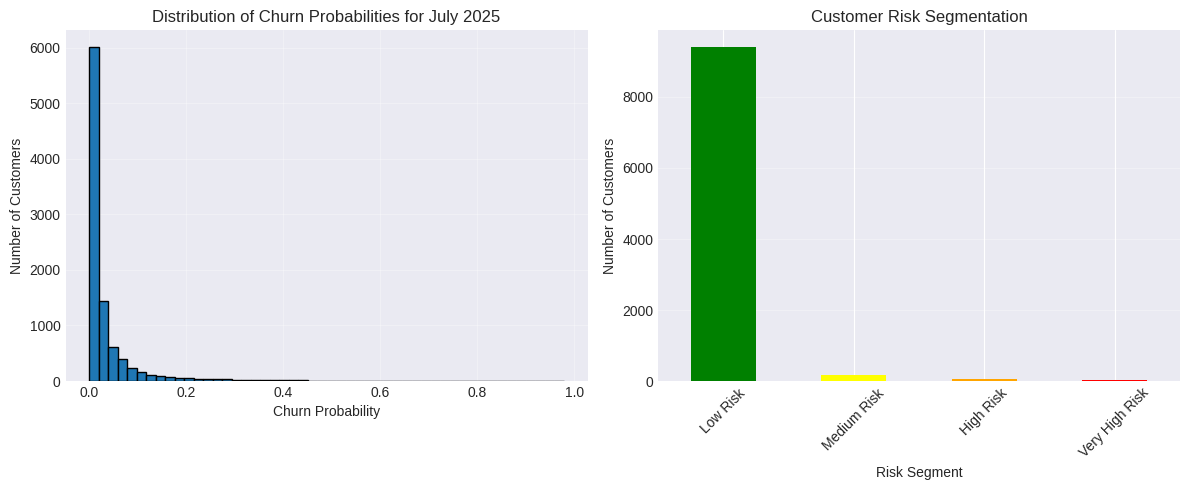


Risk Segmentation:
  Low Risk: 9406 customers (97.4%)
  Medium Risk: 160 customers (1.7%)
  High Risk: 62 customers (0.6%)
  Very High Risk: 31 customers (0.3%)


In [31]:
# Summary statistics of predictions
print("\n" + "="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(f"\nChurn probability statistics:")
print(predictions_df['Churn_Probability_July_2025'].describe())

# Distribution of churn probabilities
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(predictions_df['Churn_Probability_July_2025'], bins=50, edgecolor='black')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.title('Distribution of Churn Probabilities for July 2025')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Risk segments
risk_segments = pd.cut(predictions_df['Churn_Probability_July_2025'],
                       bins=[0, 0.3, 0.5, 0.7, 1.0],
                       labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])
risk_counts = risk_segments.value_counts().sort_index()
risk_counts.plot(kind='bar', color=['green', 'yellow', 'orange', 'red'])
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Risk Segmentation')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print segment breakdown
print("\nRisk Segmentation:")
for segment, count in risk_counts.items():
    pct = (count / len(predictions_df)) * 100
    print(f"  {segment}: {count} customers ({pct:.1f}%)")

In [32]:
# Save predictions to CSV
predictions_df.to_csv('churn_predictions_july_2025.csv', index=False)
print("\nPredictions saved to 'churn_predictions_july_2025.csv'")

# Also save full predictions with customer details
full_predictions = non_churned_customers[['MSISDN', 'PREPOST_PAID', 'BS_TYPE', 'MAIN_PLAN']].merge(
    predictions_df, on='MSISDN', how='left'
)
full_predictions.to_csv('churn_predictions_july_2025_detailed.csv', index=False)
print("Detailed predictions saved to 'churn_predictions_july_2025_detailed.csv'")


Predictions saved to 'churn_predictions_july_2025.csv'
Detailed predictions saved to 'churn_predictions_july_2025_detailed.csv'


## 7. Key Insights and Recommendations

In [33]:
print("="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

print("\n1. MODEL PERFORMANCE:")
print(f"   - Best model: {best_model_name}")
print(f"   - ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"   - This indicates {((results[best_model_name]['roc_auc']-0.5)*2*100):.1f}% better than random prediction")

print("\n2. CHURN RISK DISTRIBUTION:")
high_risk = len(predictions_df[predictions_df['Churn_Probability_July_2025'] > 0.7])
medium_risk = len(predictions_df[(predictions_df['Churn_Probability_July_2025'] > 0.5) &
                                  (predictions_df['Churn_Probability_July_2025'] <= 0.7)])
print(f"   - High risk customers (>70% probability): {high_risk}")
print(f"   - Medium risk customers (50-70% probability): {medium_risk}")
print(f"   - These {high_risk + medium_risk} customers should be prioritized for retention efforts")

print("\n3. BUSINESS RECOMMENDATIONS:")
print("   - Immediate action: Contact high-risk customers with retention offers")
print("   - Investigate common patterns among high-risk customers")
print("   - Monitor key features that drive churn (see feature importance)")
print("   - Consider A/B testing retention strategies on medium-risk segment")

print("\n4. MODEL IMPROVEMENTS FOR FUTURE:")
print("   - Collect additional data: customer satisfaction scores, complaint history")
print("   - Engineer more temporal features: acceleration of usage decline")
print("   - Try ensemble methods combining multiple models")
print("   - Implement regular model retraining pipeline")
print("   - Consider separate models for different customer segments")

KEY INSIGHTS AND RECOMMENDATIONS

1. MODEL PERFORMANCE:
   - Best model: XGBoost
   - ROC-AUC: 0.9369
   - This indicates 87.4% better than random prediction

2. CHURN RISK DISTRIBUTION:
   - High risk customers (>70% probability): 31
   - Medium risk customers (50-70% probability): 62
   - These 93 customers should be prioritized for retention efforts

3. BUSINESS RECOMMENDATIONS:
   - Immediate action: Contact high-risk customers with retention offers
   - Investigate common patterns among high-risk customers
   - Monitor key features that drive churn (see feature importance)
   - Consider A/B testing retention strategies on medium-risk segment

4. MODEL IMPROVEMENTS FOR FUTURE:
   - Collect additional data: customer satisfaction scores, complaint history
   - Engineer more temporal features: acceleration of usage decline
   - Try ensemble methods combining multiple models
   - Implement regular model retraining pipeline
   - Consider separate models for different customer segments


## 8. Additional Analysis - Threshold Optimization


Threshold Analysis:
 Threshold  Precision   Recall  F1-Score  True Positives  False Positives  False Negatives
       0.3   0.385965 0.647059  0.483516              44               70               24
       0.4   0.461538 0.617647  0.528302              42               49               26
       0.5   0.573529 0.573529  0.573529              39               29               29
       0.6   0.631579 0.529412  0.576000              36               21               32
       0.7   0.688889 0.455882  0.548673              31               14               37


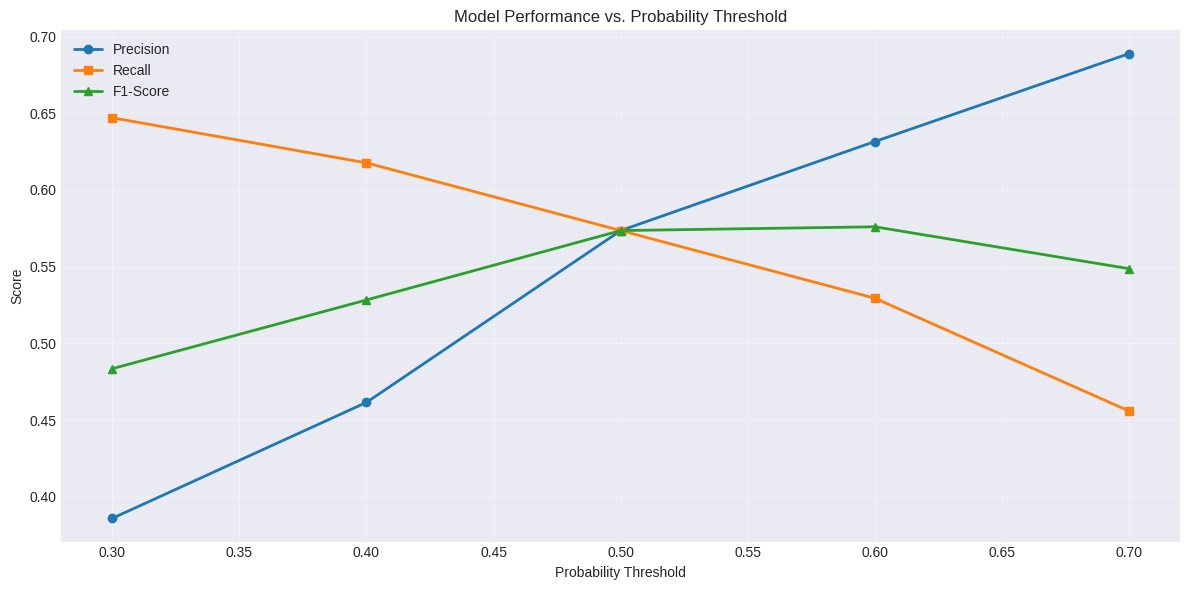

In [34]:
# Analyze different probability thresholds
# This helps determine optimal cutoff for business decisions

thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba_best >= threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    threshold_results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'True Positives': tp,
        'False Positives': fp,
        'False Negatives': fn
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(threshold_df['Threshold'], threshold_df['Precision'], marker='o', label='Precision', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], marker='s', label='Recall', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], marker='^', label='F1-Score', linewidth=2)
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Score')
ax.set_title('Model Performance vs. Probability Threshold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

This notebook has completed:
1. ✅ Comprehensive EDA on 10,000 customers with 983 features
2. ✅ Feature engineering: aggregation, encoding, imputation
3. ✅ Model development: trained 4 different algorithms
4. ✅ Model evaluation: ROC-AUC, Precision-Recall, F1-Score
5. ✅ Prediction: Generated churn probabilities for 9,659 active customers
6. ✅ Business insights: Risk segmentation and actionable recommendations
